In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import matplotlib.font_manager as fm

In [35]:
# 设置全局字体
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['SimHei'] # 设置中文字体为黑体

# 加载字体文件
font = fm.FontProperties(fname='C:\Windows\Fonts\simhei.ttf', size=16)

# 1.1 蔬菜类商品不同品类或不同单品之间可能存在一定的关联关系，请分析蔬菜各品类及单品销售量的分布规律及相互关系。

In [36]:
# Read the data
'''
# data_1: 6 个蔬菜品类的商品信息
# data_2: 销售流水明细数据
# data_3: 蔬菜类商品的批发价格
# data_4: 蔬菜类商品的近期损耗率
附件 1 中，部分单品名称包含的数字编号表示不同的供应来源。
附件 4 中的损耗率反映了近期商品的损耗情况，通过近期盘点周期的数据计算得到。

'''
data_1 = pd.read_excel('../data/附件1.xlsx')
data_2 = pd.read_excel('../data/附件2.xlsx')
data_3 = pd.read_excel('../data/附件3.xlsx')
data_4 = pd.read_excel('../data/附件4.xlsx')

In [37]:
data_1.head()

单品编码    单品名称        分类编码 分类名称
0  102900005115168    牛首生菜  1011010101  花叶类
1  102900005115199   四川红香椿  1011010101  花叶类
2  102900005115625  本地小毛白菜  1011010101  花叶类
3  102900005115748     白菜苔  1011010101  花叶类
4  102900005115762      苋菜  1011010101  花叶类

In [38]:
data_2.head()

销售日期        扫码销售时间             单品编码  销量(千克)  销售单价(元/千克) 销售类型 是否打折销售
0 2020-07-01  09:15:07.924  102900005117056   0.396         7.6   销售      否
1 2020-07-01  09:17:27.295  102900005115960   0.849         3.2   销售      否
2 2020-07-01  09:17:33.905  102900005117056   0.409         7.6   销售      否
3 2020-07-01  09:19:45.450  102900005115823   0.421        10.0   销售      否
4 2020-07-01  09:20:23.686  102900005115908   0.539         8.0   销售      否

In [39]:
data_3.head()
#将data_3中的列重命名为销售日期、单品编码和批发价格
data_3.columns = ['销售日期','单品编码','批发价格(元/千克)']
data_3.head()
#data_3.shape

销售日期             单品编码  批发价格(元/千克)
0 2020-07-01  102900005115762        3.88
1 2020-07-01  102900005115779        6.72
2 2020-07-01  102900005115786        3.19
3 2020-07-01  102900005115793        9.24
4 2020-07-01  102900005115823        7.03

In [40]:
#将data_4中的列重命名为分类编码、分类名称、平均损耗率
data_4.columns = ['分类编码','分类名称','平均损耗率']
data_4.head()
#data_4.shape

分类编码   分类名称  平均损耗率
0  1011010201    花菜类  15.51
1  1011010402  水生根茎类  13.65
2  1011010101    花叶类  12.83
3  1011010801    食用菌   9.45
4  1011010504    辣椒类   9.24

In [41]:
data_2.shape

(878503, 7)

# 1.1.1 蔬菜各品类销售量的分布规律

In [42]:
# 合并data_1和data_2
merged_data = pd.merge(data_1, data_2, on='单品编码')
# 按照分类名称进行分组，计算每个品类的销售量
sales_by_category = merged_data[merged_data['销售类型'] == '销售'].groupby('分类名称')['销量(千克)'].sum() - merged_data[merged_data['销售类型'] == '退货'].groupby('分类名称')['销量(千克)'].sum()

In [43]:
sales_by_category.index[0:6]

Index(['水生根茎类', '花叶类', '花菜类', '茄类', '辣椒类', '食用菌'], dtype='object', name='分类名称')

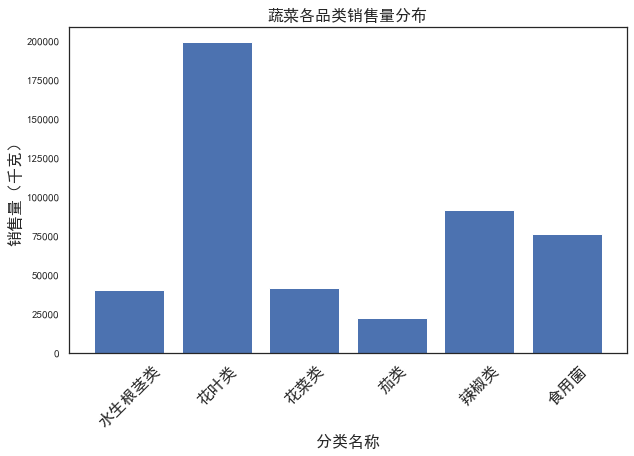

In [44]:
# plot the sales distribution
plt.figure(figsize=(10, 6)) # set the figure size to 10x6 inches
plt.bar(sales_by_category.index, sales_by_category.values)
plt.xticks(rotation=45, fontproperties = font, size = 16) # set the font for x-axis labels
plt.xlabel('分类名称', fontproperties = font) # set the font for x-axis label
plt.ylabel('销售量（千克）', fontproperties = font) # set the font for y-axis label
plt.title('蔬菜各品类销售量分布', fontproperties = font) # set the font for title
plt.savefig('../results/sales_distribution.png', dpi=300, bbox_inches='tight') # set dpi to 300 for higher resolution and save the entire figure

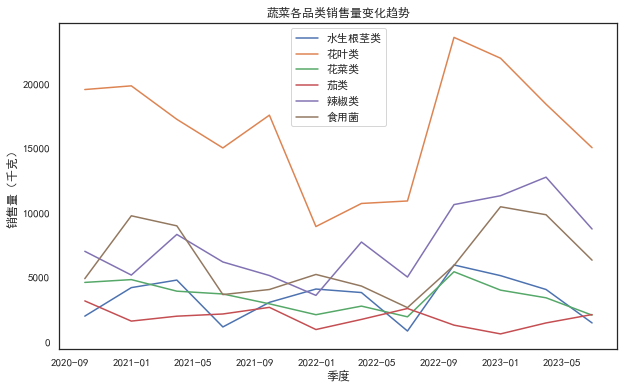

In [45]:
# 以季度为周期，可视化不同蔬菜品类销售量的变化趋势
# 将销售数据按照季度进行重采样
quarterly_sales = merged_data.resample('Q', on='销售日期')['销量(千克)'].sum()
# 将销售数据按照分类名称和季度进行分组，计算每个品类在每个季度的销售量
# sales_by_category = merged_data[merged_data['销售类型'] == '销售'].groupby(['分类名称', pd.Grouper(key='销售日期', freq='Q')])['销量(千克)'].sum() - merged_data[merged_data['销售类型'] == '退货'].groupby(['分类名称', pd.Grouper(key='销售日期', freq='Q')])['销量(千克)'].sum()
sales_by_category = merged_data[merged_data['销售类型'] == '销售'].groupby(['分类名称', pd.Grouper(key='销售日期', freq='Q')])['销量(千克)'].sum()
# 可视化销售量变化趋势
fig, ax = plt.subplots(figsize=(10, 6))
for category in sales_by_category.index.levels[0]:
    ax.plot(sales_by_category.loc[category].index, sales_by_category.loc[category].values, label=category)
ax.legend()
ax.set_xlabel('季度')
ax.set_ylabel('销售量（千克）')
ax.set_title('蔬菜各品类销售量变化趋势')
plt.savefig('../results/sales_num_trend.png', dpi=300, bbox_inches='tight')

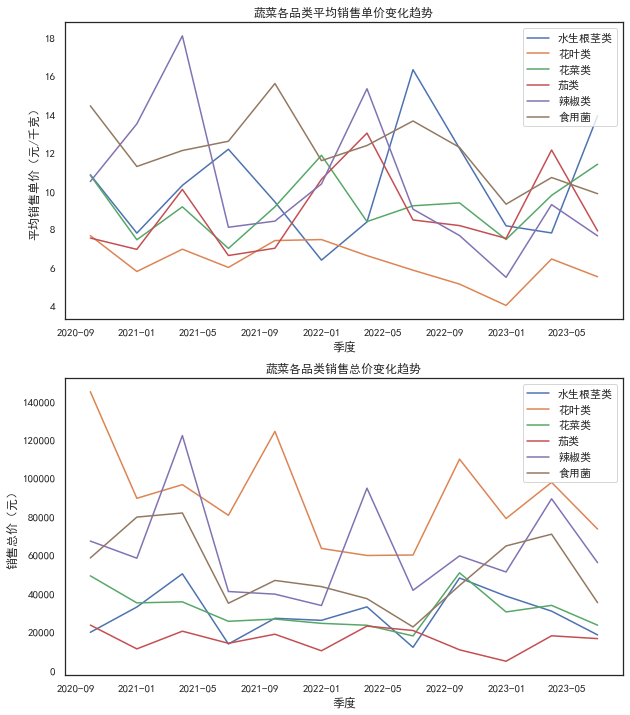

In [46]:
# 计算销售总价
merged_data['销售总价'] = merged_data['销量(千克)'] * merged_data['销售单价(元/千克)']

# 将销售数据按照季度进行重采样
quarterly_data = merged_data.resample('Q', on='销售日期').sum()

# 将销售数据按照分类名称和季度进行分组，计算每个品类在每个季度的平均销售单价和销售总价
sales_by_category = merged_data.groupby(['分类名称', pd.Grouper(key='销售日期', freq='Q')]).agg({'销售单价(元/千克)': 'mean', '销售总价': 'sum'})

# 可视化销售单价和销售总价变化趋势
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))
for category in sales_by_category.index.levels[0]:
    ax[0].plot(sales_by_category.loc[category].index, sales_by_category.loc[category]['销售单价(元/千克)'], label=category)
    ax[1].plot(sales_by_category.loc[category].index, sales_by_category.loc[category]['销售总价'], label=category)
ax[0].legend()
ax[0].set_xlabel('季度')
ax[0].set_ylabel('平均销售单价（元/千克）')
ax[0].set_title('蔬菜各品类平均销售单价变化趋势')
ax[1].legend()
ax[1].set_xlabel('季度')
ax[1].set_ylabel('销售总价（元）')
ax[1].set_title('蔬菜各品类销售总价变化趋势')
plt.savefig('../results/sales_prices_trend.png', dpi=300, bbox_inches='tight')

In [47]:
# 合并data_1、data_2、data_3和data_4
merged_data = pd.merge(data_1, data_2, on='单品编码')
merged_data = pd.merge(merged_data, data_3, on=['单品编码', '销售日期'])
merged_data = pd.merge(merged_data, data_4, on='分类编码')


In [48]:
# 计算销售总价、批发总价和损耗总价
merged_data['销售总价'] = merged_data['销量(千克)'] * merged_data['销售单价(元/千克)']
merged_data['批发总价'] = merged_data['销量(千克)'] * merged_data['批发价格(元/千克)']
merged_data['损耗总价'] = (merged_data['销量(千克)'] * merged_data['平均损耗率'] * merged_data['销售单价(元/千克)'])/100

# 将销售数据按照季度进行重采样
quarterly_data = merged_data.resample('Q', on='销售日期').sum()

# 将销售数据按照分类名称和季度进行分组，计算每个品类在每个季度的销售总价、批发总价和损耗总价，并计算每个品类在每个季度的利润
profit_by_category = (merged_data.groupby(['分类名称_x', pd.Grouper(key='销售日期', freq='Q')])
                     .agg({'销售总价': 'sum', '批发总价': 'sum', '损耗总价': 'sum'})
                     .assign(利润=lambda x: x['销售总价'] - x['批发总价'] - x['损耗总价']))

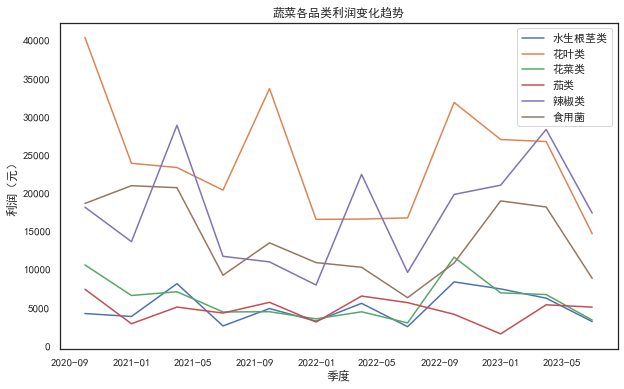

In [49]:
# 可视化利润变化趋势
fig, ax = plt.subplots(figsize=(10, 6))
for category in profit_by_category.index.levels[0]:
    ax.plot(profit_by_category.loc[category].index, profit_by_category.loc[category]['利润'], label=category)
ax.legend()
ax.set_xlabel('季度')
ax.set_ylabel('利润（元）')
ax.set_title('蔬菜各品类利润变化趋势')
plt.savefig('../results/profit_trend.png', dpi=300, bbox_inches='tight')

# 1.1.2 蔬菜各品类销售量的关联关系

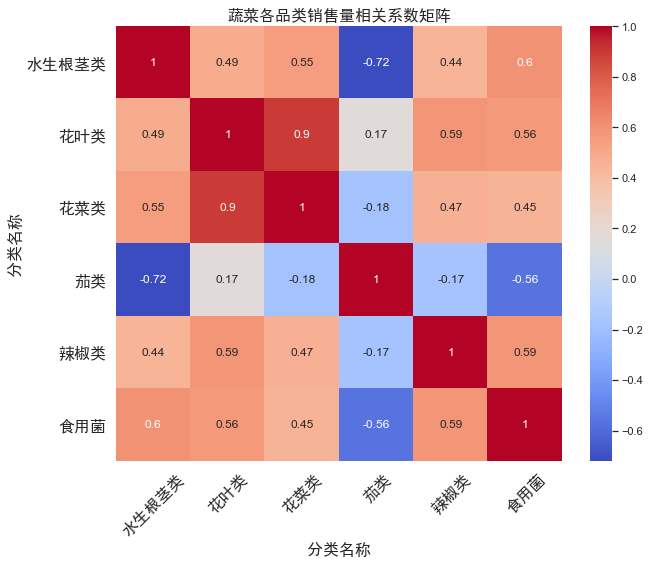

In [50]:
# 合并data_1和data_2
#plt.rcParams['axes.unicode_minus'] = False 
merged_data = pd.merge(data_1, data_2, on='单品编码')

# 将销售日期转换为日期类型
merged_data['销售日期'] = pd.to_datetime(merged_data['销售日期'])

# 按照季度和分类名称进行分组，计算每个季度每个品类的销售量
sales_by_quarter = merged_data[merged_data['销售类型'] == '销售'].groupby([pd.Grouper(key='销售日期', freq='Q'), '分类名称'])['销量(千克)'].sum() - merged_data[merged_data['销售类型'] == '退货'].groupby([pd.Grouper(key='销售日期', freq='Q'), '分类名称'])['销量(千克)'].sum()

# 将MultiIndex转换为DataFrame
sales_by_quarter = sales_by_quarter.unstack()

# 计算各品类销售量之间的相关系数
corr_matrix = sales_by_quarter.corr()

# 可视化相关系数矩阵
sns.set(style='white')
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax)
ax.set_title('蔬菜各品类销售量相关系数矩阵', fontproperties=font)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_fontproperties(font)
for tick in ax.get_yticklabels():
    tick.set_rotation(0)
    tick.set_fontproperties(font)
plt.xlabel('分类名称', fontproperties=font)
plt.ylabel('分类名称', fontproperties=font)
plt.savefig('../results/corr_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# 1.2.1 蔬菜单品销售量的分布情况

In [51]:
# 合并data_1和data_2
merged_data = pd.merge(data_1, data_2, on='单品编码')
# 按照分类名称进行分组，计算每个品类的销售量
sales_by_item = merged_data[merged_data['销售类型'] == '销售'].groupby('单品名称')['销量(千克)'].sum() - merged_data[merged_data['销售类型'] == '退货'].groupby('单品名称')['销量(千克)'].sum()

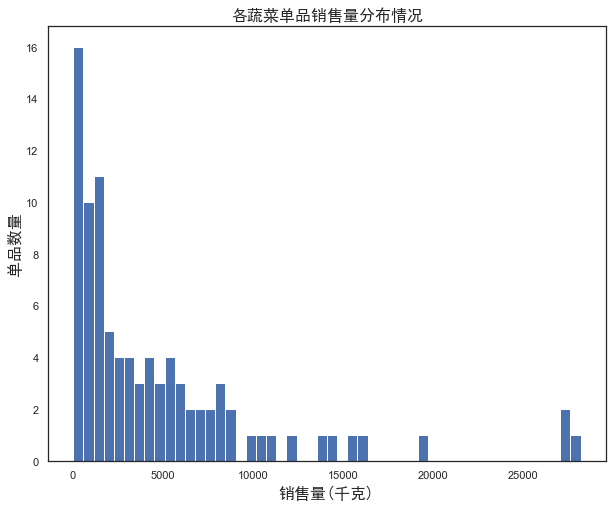

In [52]:
# 绘制销售量分布直方图
fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(sales_by_item, bins=50)
ax.set_xlabel('销售量(千克)',fontproperties=font)
ax.set_ylabel('单品数量',fontproperties=font)
ax.set_title('各蔬菜单品销售量分布情况',fontproperties=font)
plt.savefig('../results/sales_item_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

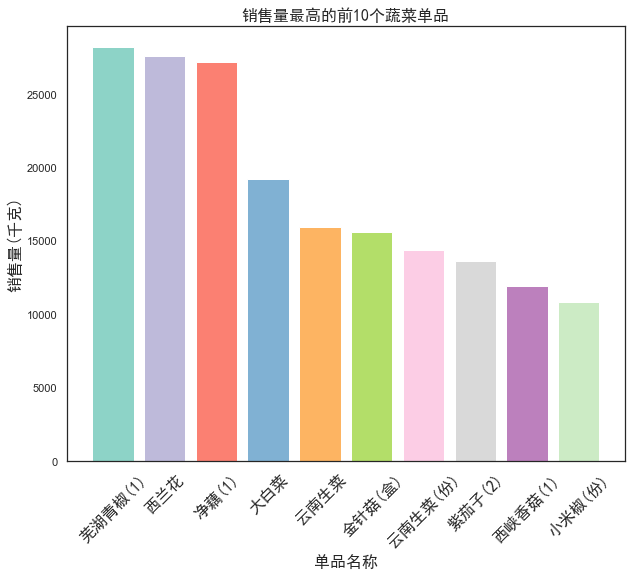

In [53]:
# 获取销售量最高的前10个单品
top_10_items = sales_by_item.sort_values(ascending=False)[:10]
# 为每个单品指定不同的颜色
colors = ['#8dd3c7', '#bebada', '#fb8072', '#80b1d3', '#fdb462', '#b3de69', '#fccde5', '#d9d9d9', '#bc80bd', '#ccebc5']
# 绘制销售量最高的前10个单品的条形图
fig, ax = plt.subplots(figsize=(10, 8))
ax.bar(top_10_items.index, top_10_items.values, color=colors)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_fontproperties(font)
ax.set_xlabel('单品名称',fontproperties=font)
ax.set_ylabel('销售量(千克)',fontproperties=font)
ax.set_title('销售量最高的前10个蔬菜单品', fontproperties=font)
plt.savefig('../results/top_10_items.png', dpi=300, bbox_inches='tight')
plt.show()

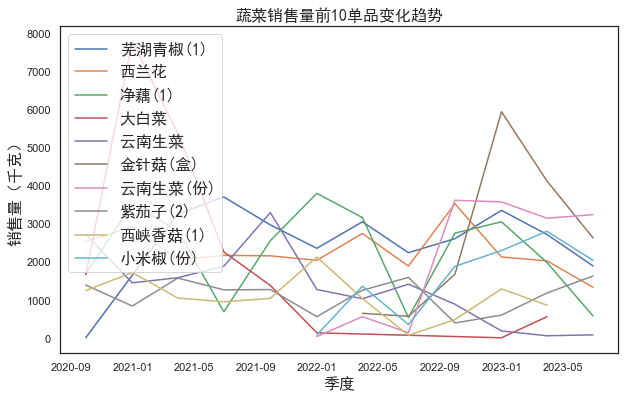

In [54]:
# 以季度为周期，可视化top10蔬菜单品销售量的变化趋势
# 将销售数据按照季度进行重采样
quarterly_sales = merged_data.resample('Q', on='销售日期')['销量(千克)'].sum()
# 将销售数据按照分类名称和季度进行分组，计算每个品类在每个季度的销售量
# sales_by_category = merged_data[merged_data['销售类型'] == '销售'].groupby(['分类名称', pd.Grouper(key='销售日期', freq='Q')])['销量(千克)'].sum() - merged_data[merged_data['销售类型'] == '退货'].groupby(['分类名称', pd.Grouper(key='销售日期', freq='Q')])['销量(千克)'].sum()
sales_by_category = merged_data[merged_data['销售类型'] == '销售'].groupby(['单品名称', pd.Grouper(key='销售日期', freq='Q')])['销量(千克)'].sum()
# 获取销量前10的蔬菜单品
top10_veggies = sales_by_category.groupby('单品名称').sum().sort_values(ascending=False).head(10).index.tolist()
# 可视化销售量变化趋势
fig, ax = plt.subplots(figsize=(10, 6))
for category in top10_veggies:
    ax.plot(sales_by_category.loc[category].index, sales_by_category.loc[category].values, label=category)
ax.legend(prop = font)
ax.set_xlabel('季度',fontproperties=font)
ax.set_ylabel('销售量（千克）',fontproperties=font)
ax.set_title('蔬菜销售量前10单品变化趋势', fontproperties=font)
plt.savefig('../results/sales_top10_trend.png', dpi=300, bbox_inches='tight')
plt.show()

# 1.2.2 蔬菜单品销售量的关联情况

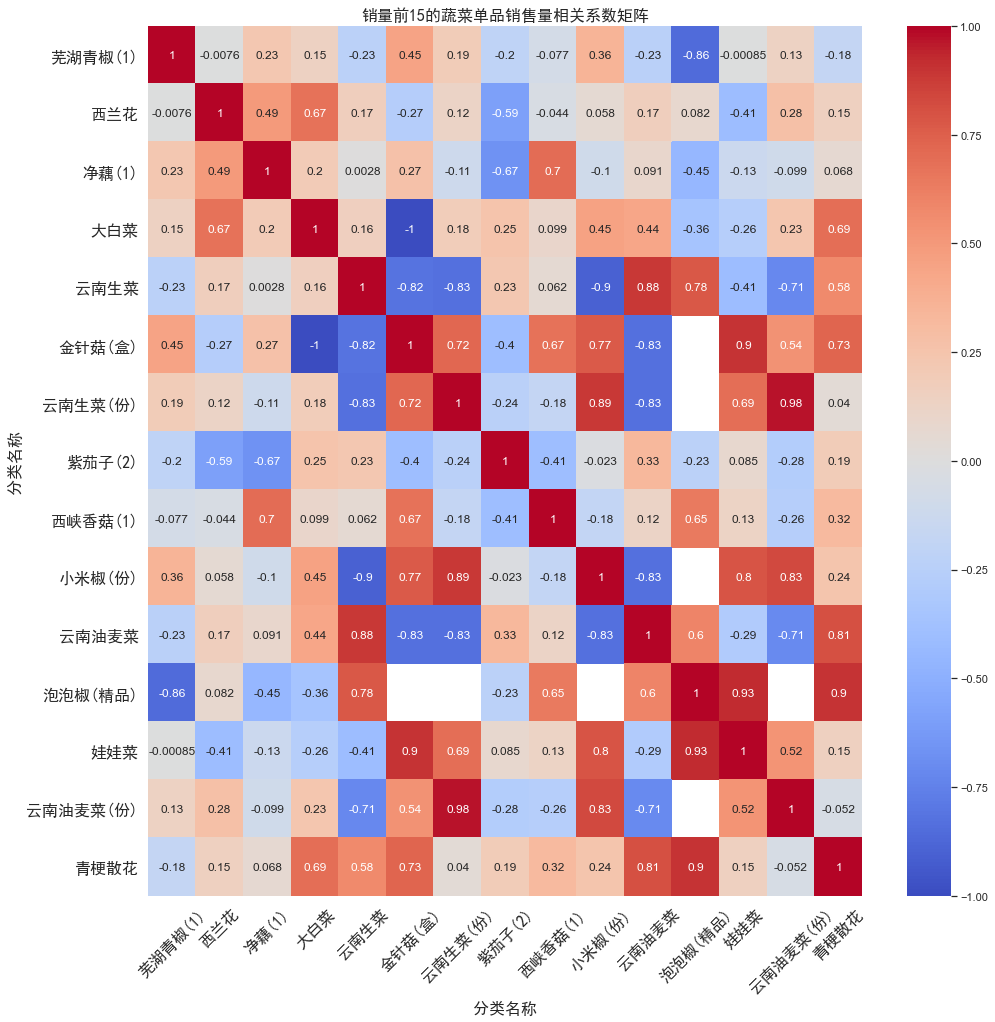

In [55]:
# 合并data_1和data_2
#plt.rcParams['axes.unicode_minus'] = False 
merged_data = pd.merge(data_1, data_2, on='单品编码')

# 将销售日期转换为日期类型
merged_data['销售日期'] = pd.to_datetime(merged_data['销售日期'])

# 按照季度和分类名称进行分组，计算每个季度每个品类的销售量
#sales_by_quarter = merged_data[merged_data['销售类型'] == '销售'].groupby([pd.Grouper(key='销售日期', freq='Q'), '单品名称'])['销量(千克)'].sum() - merged_data[merged_data['销售类型'] == '退货'].groupby([pd.Grouper(key='销售日期', freq='Q'), '单品名称'])['销量(千克)'].sum()
sales_by_quarter = merged_data[merged_data['销售类型'] == '销售'].groupby([pd.Grouper(key='销售日期', freq='Q'), '单品名称'])['销量(千克)'].sum() 
# 将MultiIndex转换为DataFrame
sales_by_quarter = sales_by_quarter.unstack()

# 计算各品类销售量之间的相关系数
corr_matrix = sales_by_quarter.corr()

# 取销量前15的蔬菜单品
top_veggies = sales_by_quarter.sum().sort_values(ascending=False).head(15).index

# 取相关系数矩阵中销量前15的蔬菜单品的相关系数
corr_matrix_top_veggies = corr_matrix.loc[top_veggies, top_veggies]

# 可视化相关系数矩阵
sns.set(style='white')
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(corr_matrix_top_veggies, annot=True, cmap='coolwarm', ax=ax)
ax.set_title('销量前15的蔬菜单品销售量相关系数矩阵', fontproperties=font)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_fontproperties(font)
for tick in ax.get_yticklabels():
    tick.set_rotation(0)
    tick.set_fontproperties(font)
plt.xlabel('分类名称', fontproperties=font)
plt.ylabel('分类名称', fontproperties=font)
plt.savefig('../results/corr_matrix_top_veggies.png', dpi=300, bbox_inches='tight')
plt.show()